In [14]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

# download data from PyTorch

In [4]:
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False,
                                          transform=transforms.ToTensor())

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# define model classes

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [16]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [28]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate RNN
        out, h0 = self.rnn(x, h0)
        
        # output from the last time step's hidden state
        out = self.fc(h0)
        
        # reshape for batch sizes to match
        return out.view(-1, self.num_classes)

# LSTM results

In [22]:
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

In [23]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
# Train the model
loss_LSTM = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        loss_LSTM += [loss.item()]

Epoch [1/2], Step [100/600], Loss: 0.6583
Epoch [1/2], Step [200/600], Loss: 0.4319
Epoch [1/2], Step [300/600], Loss: 0.1202
Epoch [1/2], Step [400/600], Loss: 0.2056
Epoch [1/2], Step [500/600], Loss: 0.1048
Epoch [1/2], Step [600/600], Loss: 0.0982
Epoch [2/2], Step [100/600], Loss: 0.1932
Epoch [2/2], Step [200/600], Loss: 0.1409
Epoch [2/2], Step [300/600], Loss: 0.1285
Epoch [2/2], Step [400/600], Loss: 0.0787
Epoch [2/2], Step [500/600], Loss: 0.0423
Epoch [2/2], Step [600/600], Loss: 0.0660


In [11]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 
    acc_LSTM = 100 * correct / total

Test Accuracy of the model on the 10000 test images: 97.37 %


In [43]:
# Save the model checkpoint
torch.save(model.state_dict(), 'lstm_model_MNIST.ckpt')

# GRU results

In [25]:
model = GRUModel(input_size, hidden_size, num_layers, num_classes).to(device)

In [26]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
# Train the model
loss_GRU = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        loss_GRU += [loss.item()]

Epoch [1/2], Step [100/600], Loss: 0.5605
Epoch [1/2], Step [200/600], Loss: 0.1667
Epoch [1/2], Step [300/600], Loss: 0.1346
Epoch [1/2], Step [400/600], Loss: 0.0548
Epoch [1/2], Step [500/600], Loss: 0.1228
Epoch [1/2], Step [600/600], Loss: 0.0536
Epoch [2/2], Step [100/600], Loss: 0.1589
Epoch [2/2], Step [200/600], Loss: 0.0501
Epoch [2/2], Step [300/600], Loss: 0.0574
Epoch [2/2], Step [400/600], Loss: 0.1284
Epoch [2/2], Step [500/600], Loss: 0.0124
Epoch [2/2], Step [600/600], Loss: 0.0683


In [28]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
    acc_GRU = 100 * correct / total

Test Accuracy of the model on the 10000 test images: 97.46 %


In [50]:
# Save the model checkpoint
torch.save(model.state_dict(), 'gru_model_MNIST.ckpt')

# regular RNN results

In [52]:
model = RNNModel(input_size, hidden_size, num_classes).to(device)

In [53]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [54]:
# Train the model
loss_RNN = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        loss_RNN += [loss.item()]

Epoch [1/2], Step [100/600], Loss: 1.7761
Epoch [1/2], Step [200/600], Loss: 2.1189
Epoch [1/2], Step [300/600], Loss: 1.6860
Epoch [1/2], Step [400/600], Loss: 1.4103
Epoch [1/2], Step [500/600], Loss: 1.3335
Epoch [1/2], Step [600/600], Loss: 1.5217
Epoch [2/2], Step [100/600], Loss: 1.3800
Epoch [2/2], Step [200/600], Loss: 1.0073
Epoch [2/2], Step [300/600], Loss: 1.4717
Epoch [2/2], Step [400/600], Loss: 2.0381
Epoch [2/2], Step [500/600], Loss: 1.4065
Epoch [2/2], Step [600/600], Loss: 1.6151


In [55]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
    acc_RNN = 100 * correct / total

Test Accuracy of the model on the 10000 test images: 47.01 %


In [56]:
# Save the model checkpoint
torch.save(model.state_dict(), 'rnn_model_MNIST.ckpt')

# plot results

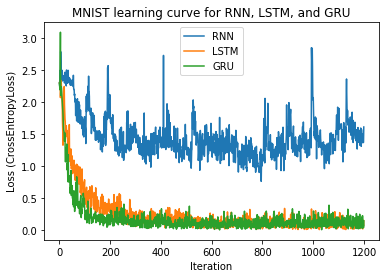

In [65]:
plt.xlabel("Iteration")
plt.ylabel("Loss (CrossEntropyLoss)")
plt.title("MNIST learning curve for RNN, LSTM, and GRU")
plt.plot(loss_RNN, label="RNN")
plt.plot(loss_LSTM, label="LSTM")
plt.plot(loss_GRU,label="GRU")
plt.legend()

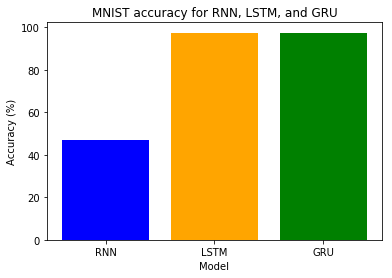

In [33]:
acc = {"RNN": acc_RNN, "LSTM": acc_LSTM, "GRU": acc_GRU}
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("MNIST accuracy for RNN, LSTM, and GRU")
plt.bar(range(len(acc)), list(acc.values()), color=('blue','orange','green'), align='center')
plt.xticks(range(len(acc)), list(acc.keys()))
plt.show()